## II) 2D Convolutional Autoencoder for MRI's

### Importing Modules

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import nibabel as nib
import re
import numpy as np
import xml.dom.minidom as minidom
import cv2
from skimage.transform import resize

In [2]:
import os
import tempfile
import shutil
import gc

import monai
from monai.data import ImageDataset
from monai.transforms import Compose, EnsureChannelFirst, RandAdjustContrast, Spacing
from monai.config import print_config

print_config()

MONAI version: 0.8.1
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.2
scikit-image version: 0.17.2
Pillow version: 8.4.0
Tensorboard version: 2.6.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.1+cu111
tqdm version: NOT INSTALLED or UNKNOWN VERSION.
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



### CPU OR GPU Selection

In [3]:
device = "cpu"

In [4]:
device

'cpu'

- Find out what <b>CPU</b> we are using:

In [5]:
import platform
platform.processor()

'x86_64'

- This command will return a boolean (True/False) letting you know if a <b>GPU</b> is available.

In [6]:
import torch
use_cuda = torch.cuda.is_available()

In [7]:
use_cuda

True

In [8]:
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 8005
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 3090
__CUDA Device Total Memory [GB]: 25.43812608


### Selecting a GPU to use

In [9]:
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ",device)

Device:  cuda


- Code if we want to use <b>specific GPU</b>:

In [10]:
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Device: ",device)

Device:  cuda:0


## Load MRI Data

In [5]:
img_path_test = "/UKBB/NIFTI/"
regex_mri = re.compile(r'la_4ch.nii.gz')

# Find all files that match the pattern
matching_files = []
for root, dirs, files in os.walk(img_path_test):
    for file in files:
        if regex_mri.search(file):
            matching_files.append(os.path.join(root, file))

# Sort the files by their names
matching_files.sort()

In [6]:
# List of File Names
mri_names = []

number_of_files = 3447 #50000
i = 0
break_outer_loop = False

# Process the sorted files
for i, file in enumerate(matching_files[:number_of_files]):
    
    i = i + 1
    print('Found a new MRI Image in the path: ', os.path.join(root, file))

    mri_names.append(os.path.join(root, file))


    if (i == number_of_files):
        break_outer_loop = True
        break
    if break_outer_loop:
        break

Found a new MRI Image in the path:  /UKBB/NIFTI/10/1000195/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1000231/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1000384/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1000500/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1000511/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1000771/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1000846/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1000874/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1001009/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1001234/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1001553/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1001596/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1001808/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/

Found a new MRI Image in the path:  /UKBB/NIFTI/10/1093367/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1093589/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1093616/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1093664/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1093685/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1093866/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1094007/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1094213/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1094226/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1094287/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1094315/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1094360/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/1094442/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/10/

Found a new MRI Image in the path:  /UKBB/NIFTI/11/1177054/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/11/1177068/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/11/1177164/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/11/1177310/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/11/1177373/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/11/1177411/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/11/1177543/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/11/1177578/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/11/1177692/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/11/1177793/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/11/1177812/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/11/1177929/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/11/1177977/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/11/

Found a new MRI Image in the path:  /UKBB/NIFTI/12/1289782/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/12/1289813/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/12/1289845/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/12/1289899/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/12/1290143/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/12/1290157/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/12/1290300/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/12/1290386/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/12/1290774/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/12/1290788/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/12/1290876/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/12/1291074/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/12/1291271/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/12/

Found a new MRI Image in the path:  /UKBB/NIFTI/13/1370596/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/13/1370730/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/13/1370876/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/13/1370966/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/13/1371021/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/13/1371329/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/13/1371338/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/13/1371342/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/13/1371495/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/13/1371620/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/13/1371675/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/13/1371735/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/13/1371782/la_4ch.nii.gz
Found a new MRI Image in the path:  /UKBB/NIFTI/13/

In [15]:
# img_path_test = "/UKBB/NIFTI/"
# regex_mri = re.compile(r'la_4ch.nii.gz')
# mris = []

# # List of File Names
# mri_names = []

# number_of_files = 50000
# i = 0
# break_outer_loop = False

# for root, dirs, files in os.walk(img_path_test):
#     for file in files:
#         if regex_mri.search(file):
#             i = i + 1
#             print('Found a new MRI Image in the path: ', os.path.join(root, file))
            
#             mri_names.append(os.path.join(root, file))

            
#             if (i == number_of_files):
#                 break_outer_loop = True
#                 break
#             if break_outer_loop:
#                 break
#         if break_outer_loop:
#             break
#     if break_outer_loop:
#         break


In [7]:
len(mri_names)

3447

### Tensors and DataLoader 

In [8]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Normalize

class CustomDataset(Dataset):
    def __init__(self, mri_data):
        self.mri_data = mri_data
        self.transform = Normalize(0, 1)
        
    def __len__(self):
        return len(self.mri_data)

    def __getitem__(self, idx):
        mri_file = self.mri_data[idx]
        
        # Load MRI data
        mri_img = nib.load(mri_file).get_fdata()
        
        ##################################################
        ##############    Temporary    ###################
        # We will return only 1 slice from the MRI Images to reduce the computational time
        mri_img = mri_img[...,0]  # select a single slice
        mri_img = resize(mri_img, (128, 128), anti_aliasing=True)  # resize
        ##################################################
        
        # Resize the data array to 128x128 pixels along the first and second dimensions
        # mri_img = resize(mri_img, (128, 128, 1, 50), anti_aliasing=True)
        
        #mri_img = mri_img.squeeze(2)  # remove the singleton dimension
        
        
        mri_tensor = torch.tensor(mri_img, dtype=torch.float32)
        mri_tensor = mri_tensor.permute(2, 0, 1)  # swap the dimensions to (channels, height, width)
        mri_tensor = self.transform(mri_tensor)  # apply normalization transform
        
        return mri_tensor

In [9]:
dataset = CustomDataset(mri_names)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True) # Shuffle the data in every epoch of the Training

## UNET Model Architecture

The UNet architecture is a convolutional neural network that is commonly used for image segmentation tasks. It consists of an encoder, which downsamples the input image to extract high-level features, and a decoder, which upsamples the features to produce a segmentation mask that has the same size as the input image.

In this particular implementation, the UNet class is used to define the architecture of the encoder and decoder networks. The mri_encoder is initialized as an instance of the UNet class with input and output channels both set to 1. This means that the encoder will take in a single-channel MRI image and output a single-channel feature map. The bilinear=True argument specifies that the decoder should use bilinear interpolation for upsampling, which is a common approach in UNet architectures.

Similarly, the mri_decoder is also initialized as an instance of the UNet class with input and output channels both set to 1, and bilinear=True argument set to enable bilinear interpolation for upsampling.

In [20]:
torch.cuda.empty_cache()

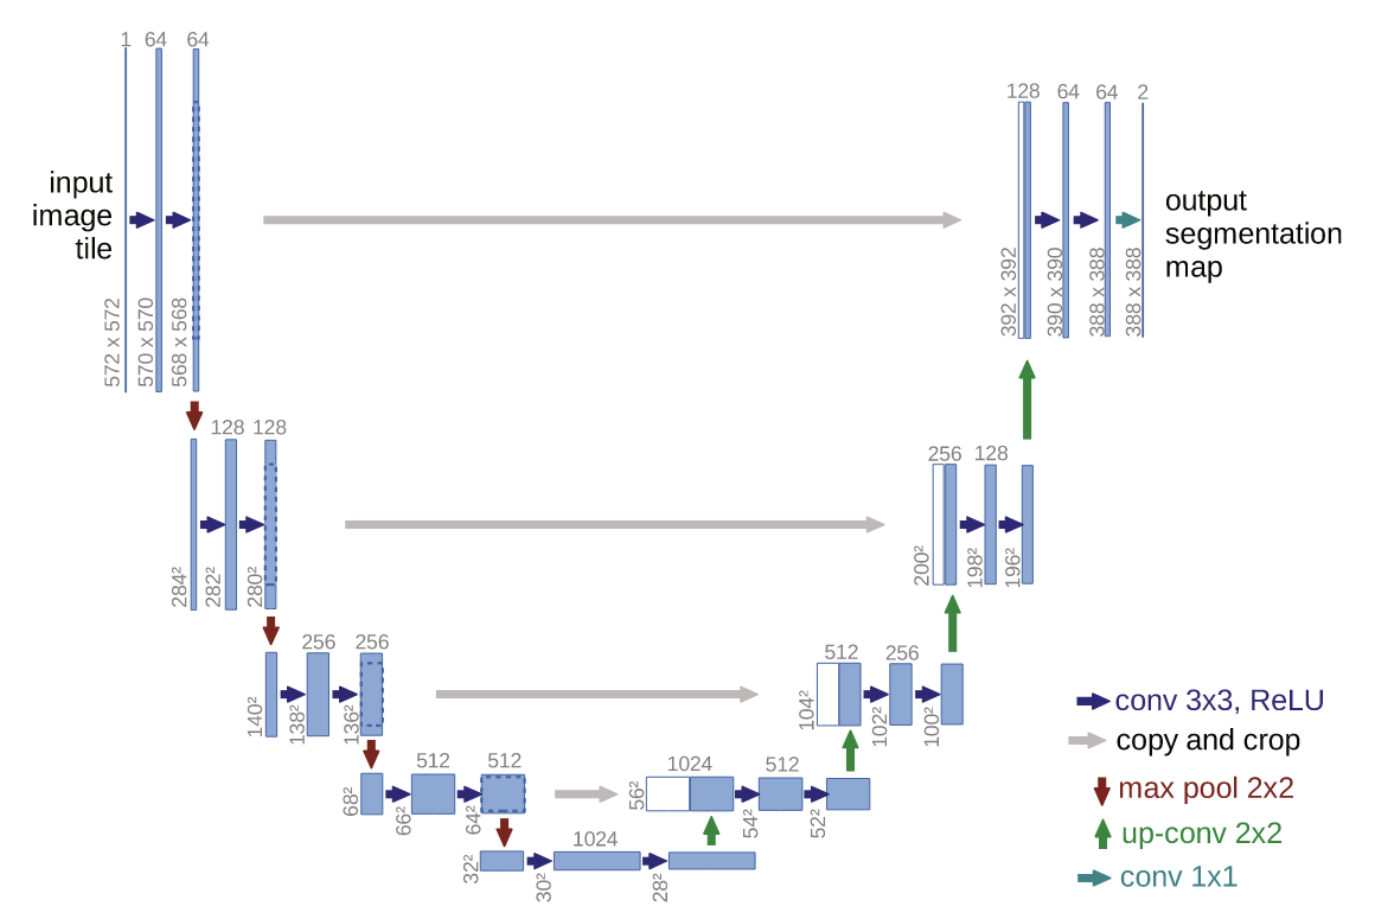

First, we need the <b>basic building block</b>, which is a composition of a convolutional operation, a normalization layer and an activation function (x2):

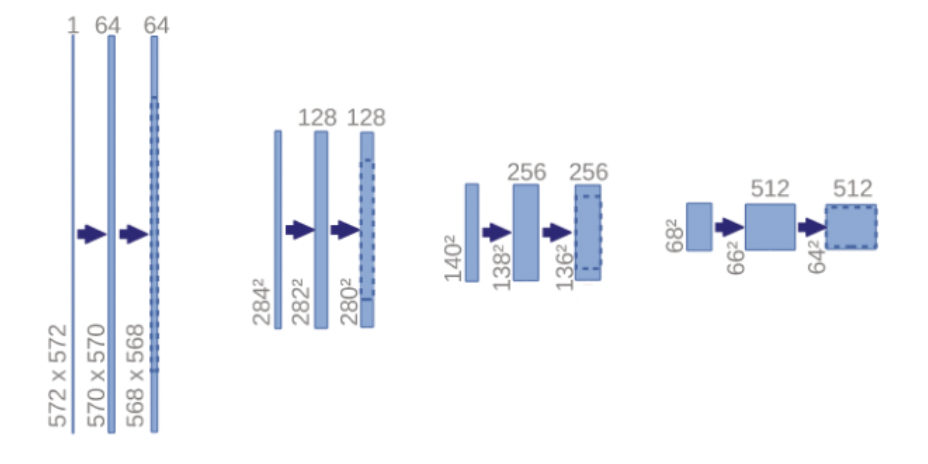

In [21]:
class DoubleConv(nn.Module):
    '''
    |------|    |------|    |------|    |------|    |------|    |------|
    | Conv | => | [BN] | => | ReLU | => | Conv | => | [BN] | => | ReLU |
    |------|    |------|    |------|    |------|    |------|    |------|
    '''
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            # One
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            # Two
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

The <b>downsampling block</b>:

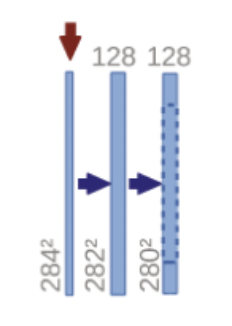

In [22]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            # Use the previous block
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

and the <b>upsampling block</b>:

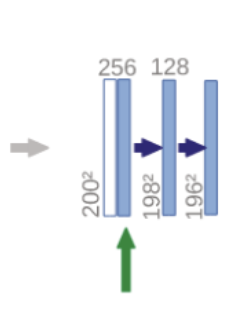

In [23]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1):
        x1 = self.up(x1)
        return self.conv(x1)

We modified the traditional Upsampling block of the UNET model, so that we don't get information from the equivalent layer in the encoding path. Therefore, in this implementation the forward method only takes one input tensor x1 from the previous block, and the x2 argument and corresponding concatenation code are removed.

The <b>last layer</b> is simply a 1x1 convolution (light blue color in the figure above) so we create another class for it as well:

In [24]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

### 2D Convolutional Autoencoder for MRI's

In [25]:
class Encoder(nn.Module):
    def __init__(self, n_channels, bilinear=True):
        super(Encoder, self).__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64) #DoubleConv(Input channel, output channel)
        
        self.down1 = Down(64, 128) # Down(Input channel, output channel)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 256)  # reduce spatial resolution and channels
        
        self.max = nn.MaxPool2d(kernel_size=16)
        self.avg = nn.AvgPool2d(kernel_size=16)
        self.aavg = nn.AdaptiveAvgPool2d((1, 1))
        self.c = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=16, stride=16)
        self.dropout = nn.Dropout2d(p=0.2)
        
        self.down4 = Down(256, 256)  
        self.down5 = Down(256, 256)  
        self.down6 = Down(256, 256)  
        self.down7 = Down(256, 256)

    def forward(self, x):
        
        ## DownSampling in order from 128x128 --> 64x64 --> 32x32 --> 16x16 --> 1x1
        
        x1 = self.inc(x)# x1: 64 channels and 128x128
        x2 = self.down1(x1)# x2: 128 channels and 64x64
        x3 = self.down2(x2)# x3: 256 channels and 32x32
        x4 = self.down3(x3)# x4: 256 channels and 16x16
        
        # Using MaxPooling to reduce the spatial dimensions from 16x16 to 1x1 by keeping the Max Value
        x5 = self.max(x4)
        
        return x5

        

class Decoder(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(Decoder, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        

        ## UpSampling in order from 1x1 --> 2x2 --> 4x4 --> 8x8 --> 16x16 --> 32x32 --> 64x64 --> 128x128
        
        ## Up(input channel, output channel)
        self.up1 = Up(256, 256)
        self.up2 = Up(256, 256)
        self.up3 = Up(256, 256)
        self.up4 = Up(256, 256)
        self.up5 = Up(256, 256)
        
        self.up6 = Up(256, 128)
        self.up7 = Up(128, 64)
        
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        
        x = self.up1(x) # 1x1
        x = self.up2(x) # 2x2
        x = self.up3(x) # 4x4
        x = self.up4(x) # 8x8
        x = self.up5(x) # 16x16
        x = self.up6(x) # 32x32
        x = self.up7(x) # 64x64
        logits = self.outc(x) # 128x128

        return logits


    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.encoder = Encoder(n_channels, bilinear)
        self.decoder = Decoder(64, n_classes, bilinear)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [30]:
class MriAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        ##############    2D Convolutional Autoencoder for the MRI's.   ##############
        # Building a UNet-based Convolutional encoder-decoder for MRI input
        self.mri_encoder = Encoder(1, bilinear=True)
        self.mri_decoder = Decoder(512 // 2, 1, bilinear=True)


    def forward(self, mri_image):
        #print("MRI encoder input: ", mri_image.shape)
        mri_encoded = self.mri_encoder(mri_image)
        
        #print("MRI encoder output: ", mri_encoded.shape)
        decoded_mri = self.mri_decoder(mri_encoded)

        return mri_encoded, decoded_mri

In [38]:
mri_autoencoder = MriAutoencoder().to(device)
loss_function = torch.nn.L1Loss() # MAE
optimizer = torch.optim.AdamW(mri_autoencoder.parameters(), lr = 1e-3)

### Model Number of Parameters 

In [39]:
pytorch_total_params = sum(p.numel() for p in mri_autoencoder.parameters() if p.requires_grad)
print("Total number of parameters for my model: ", pytorch_total_params)

Total number of parameters for my model:  27338497


### Pre-Train for MRI's

In [40]:
epochs = 30 #100
outputs = []
mri_losses = []

encoded_mris = []

print("Starting Training Loop...","\n")

for epoch in range(epochs):
    
    print(f"Epoch {epoch+1}\n-------------------------------")
    
    for i, (mri_image) in enumerate(dataloader):

        # Send the training data to the GPU
        mri_image = mri_image.to(device)

        # Output of CustomModel (Dont have to pass the reconstructed items to the GPU)
        encoded_mri, reconstructed_mri = mri_autoencoder(mri_image)
        
        if (epoch == 99):
            encoded_mris.append(encoded_mri)

        # Calculating the loss function
        loss_mri = loss_function(reconstructed_mri, mri_image)

        # The gradients are set to zero,the gradient is computed and stored and .step() performs parameter update
        optimizer.zero_grad()
        loss_mri.backward()
        optimizer.step()

        # Storing the losses in a list for plotting
        print(loss_mri.item())
        mri_losses.append(loss_mri.item())
        #outputs.append((epochs, mri_image, reconstructed_mri))
            
    
    print("")
    
print("")
print("Done!")

Starting Training Loop... 

Epoch 1
-------------------------------
86.4632568359375
84.74996948242188
90.09745788574219
85.38337707519531
85.1565933227539
87.14242553710938
84.21392822265625
85.83985137939453
83.13732147216797
82.76661682128906
82.38750457763672
84.92694854736328
83.61505889892578
86.39639282226562
82.73609924316406
89.63948059082031
82.35306549072266
82.43975830078125
86.24227905273438
82.76127624511719
85.14427185058594
83.74012756347656
89.12229919433594
79.0841064453125
87.21930694580078
79.2493667602539
81.36751556396484
82.55171966552734
81.34538269042969
80.90998840332031
85.484130859375
87.32211303710938
84.9334716796875
84.43832397460938
82.88137817382812
82.95203399658203
82.6146011352539
88.62203979492188
87.54625701904297
82.66140747070312
85.66337585449219
82.82981872558594
87.2297134399414
82.44652557373047
84.464111328125
78.44941711425781
79.53797912597656
85.72557830810547
86.296142578125
83.74897766113281
85.13845825195312
86.4225845336914
80.6224975

58.23638916015625
52.98310470581055
58.496002197265625
52.80048370361328
55.87095642089844
53.891517639160156
53.11176300048828
56.88481903076172
51.98460388183594
54.90383529663086
52.672969818115234
56.837059020996094
54.69457244873047
49.58934020996094
53.9729118347168
55.667579650878906
56.861961364746094
52.62744140625
50.12004852294922
54.20329284667969
56.36695098876953
54.90753173828125
57.902610778808594
51.442779541015625
51.44065856933594
60.95915222167969
56.5594596862793
55.56037139892578
56.024478912353516
50.44331359863281
53.12749481201172
55.94403839111328
55.19983673095703
51.538612365722656
53.73849868774414
50.104156494140625
55.22185516357422
55.2747802734375
54.102848052978516
57.42051315307617
51.54139709472656
55.320884704589844
53.77837371826172
51.957069396972656
57.758392333984375
53.853004455566406
52.867183685302734
56.089141845703125
53.51355743408203
51.74917984008789
50.014610290527344
52.49779510498047
54.122352600097656
50.623104095458984
56.7171134948

39.06425094604492
39.02681350708008
42.02946472167969
41.189266204833984
39.560272216796875
36.803428649902344
41.69190216064453
38.869895935058594
38.701622009277344
40.94826126098633
37.33713912963867
39.21406555175781
39.57683563232422
40.18476104736328
37.50680923461914
41.136932373046875
37.813743591308594
40.66376876831055
40.57781982421875
39.80171203613281
39.45323944091797
40.694297790527344
38.8394889831543
39.21814727783203
40.6966552734375
38.028526306152344
39.87470245361328
38.81452178955078
37.989463806152344
37.237178802490234
36.313812255859375
39.96010208129883
38.26969528198242
36.120079040527344
37.852256774902344
40.06640625
41.4771842956543
41.2847785949707
39.21403503417969
38.642555236816406
37.53522491455078
40.08034133911133
40.490806579589844
39.80934143066406
38.72457504272461
41.83184814453125
40.23609924316406
39.09316635131836
37.44084167480469
40.247310638427734
39.48604965209961
39.07440185546875
41.714439392089844
38.53455352783203
39.63515090942383
38

37.33397674560547
38.79912567138672
39.678497314453125
35.601783752441406
35.72459411621094
37.54606246948242
37.7366943359375
36.593040466308594
37.681087493896484
36.203277587890625
37.466861724853516
37.1280403137207
37.34290313720703
34.30773162841797
35.91423034667969
39.44365692138672
36.449745178222656
35.26759719848633
37.51895523071289
36.36297607421875
37.828521728515625
38.158721923828125
36.02460479736328
37.64008331298828
37.86023712158203
38.18545150756836
37.310142517089844
40.76552963256836
37.86417770385742
39.468055725097656
33.34564208984375
36.662845611572266
36.72538757324219
38.29203414916992
38.166473388671875
35.56203842163086
35.99225616455078
37.95501708984375
37.82845687866211
37.669837951660156
37.44718933105469
38.72471237182617
35.64060974121094
33.75372314453125
36.450313568115234
35.67945861816406
41.52338409423828
36.796974182128906
36.566680908203125
37.135311126708984
36.212554931640625
38.81361389160156
38.01308059692383
36.973533630371094
38.2448806

35.46936798095703
36.94237518310547
37.78437423706055
34.93171691894531
37.64962387084961
36.237548828125
34.96253204345703
35.730926513671875
37.16320037841797
36.55814743041992
37.0225830078125
34.841346740722656
34.85189437866211
36.55548095703125
36.33938217163086
34.1705436706543
37.24155807495117
35.32898712158203
34.88311004638672
36.29450225830078
36.91814041137695
36.02031707763672
36.0097770690918
35.56232452392578
37.564449310302734
36.625457763671875
35.47852325439453
39.946868896484375
38.32598114013672
37.40010452270508
35.1377067565918
35.54429626464844
33.76767349243164
34.99568176269531
34.07312774658203
35.030277252197266
36.12614059448242
32.723670959472656
37.03956604003906
37.491424560546875
37.24208068847656
37.91377258300781
36.942527770996094
35.61758804321289
32.98724365234375
35.70323181152344
36.62925720214844
33.68742752075195
36.524112701416016
34.48250961303711
36.85700607299805
36.91303634643555
36.34484100341797
37.127342224121094
37.810394287109375
37.6

33.063507080078125
35.00954818725586
36.229122161865234
35.42243194580078
36.67941665649414
34.07665252685547
34.69331741333008
35.014930725097656
33.72400665283203
34.274070739746094
32.81667709350586
40.576393127441406
32.99506759643555
35.776878356933594
34.66484069824219
34.969970703125
35.151512145996094
34.30626678466797
35.94871520996094
33.770240783691406
34.265106201171875
33.26318359375
36.501708984375
33.863800048828125
35.30609893798828
35.073646545410156
34.426719665527344
36.1099853515625
36.00282287597656
35.04203796386719
37.33574676513672
34.728023529052734
36.47494888305664
34.68841552734375
34.097633361816406
33.45759201049805
36.192596435546875
33.7391357421875
37.56941223144531
34.2866096496582
32.760643005371094
33.377506256103516
36.7634391784668
36.15308380126953
34.467689514160156
35.844207763671875
34.873779296875
35.68794250488281
33.7028694152832
36.40013122558594
37.39099884033203
35.122520446777344
34.50464630126953
34.84233856201172
34.46498107910156
34.9

33.370506286621094
33.462303161621094
33.301368713378906
35.200965881347656
31.135133743286133
34.258399963378906
31.9849853515625
31.844646453857422
35.25790786743164
31.78274917602539
32.48335647583008
32.799049377441406
34.205474853515625
32.549407958984375
31.762170791625977
35.01441955566406
32.39103317260742
32.290687561035156
34.546627044677734
33.64176559448242
35.438541412353516
35.447959899902344
33.583980560302734
34.25804901123047
37.14924621582031
34.18195343017578
33.886322021484375
34.054588317871094
34.486358642578125
36.17493438720703
36.48143768310547
36.486305236816406
34.491371154785156
34.9317741394043
34.43865966796875
34.78692626953125
32.30060577392578
34.88720703125
34.73308563232422
30.95118522644043
35.60839080810547
34.83504867553711
34.02809524536133
33.2120361328125
32.08882522583008
35.046138763427734
33.94666290283203

Epoch 26
-------------------------------
32.51791763305664
33.2997932434082
34.21199417114258
31.857114791870117
32.45912170410156
36.795

33.45523452758789
32.75130081176758
33.64733123779297
32.77949523925781
35.05172348022461
33.85032653808594
32.0871467590332
32.029754638671875
35.100067138671875
35.46769714355469
32.59708023071289
31.910388946533203
32.48970031738281
32.10585021972656
35.6138801574707
32.39764404296875
33.94626998901367
35.43418884277344
35.09796142578125
31.461273193359375
32.474884033203125
33.54419708251953
35.08391571044922
37.1972770690918
32.4569206237793
32.284568786621094
33.485572814941406
35.549034118652344
32.598777770996094
34.21030044555664
35.04885482788086
32.243614196777344
37.581634521484375
32.052616119384766
35.454566955566406
33.437644958496094
33.63008117675781
36.22694396972656

Epoch 30
-------------------------------
33.32555389404297
32.876182556152344
34.36219024658203
34.72483825683594
35.227882385253906
33.453094482421875
31.31533432006836
35.550262451171875
30.924652099609375
32.80088424682617
34.008026123046875
33.42288589477539
32.13142395019531
31.4800968170166
34.1183

KeyboardInterrupt: 

### Save the encoded_mris for Latent Representation

In [ ]:
len(encoded_mris)

In [35]:
# Define the file path
file_path = 'encoded_pretrained/mri_encoded.pth'

# Check if the file exists
if os.path.exists(file_path):
    # Delete the file
    os.remove(file_path)

In [36]:
torch.save(encoded_mris, file_path)

### MRI Loss

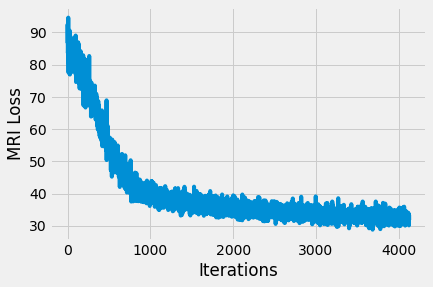

In [62]:
import matplotlib.pyplot as plt

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('MRI Loss')

# Plotting the last 200 values
plt.plot(mri_losses[-10000:])
plt.show()

### Plotting the Original and Reconstructed Image

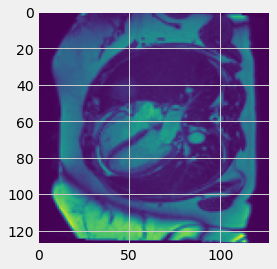

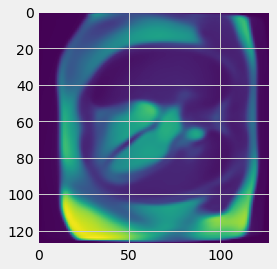

In [63]:
# Plotting some sample images

for i, item in enumerate(mri_image):
    # Reshape the array for plotting
    item = item.reshape(128, 128)
    plt.imshow(item.cpu().detach().numpy())
    plt.show()
    break

for i, item in enumerate(reconstructed_mri):
    item = item.reshape(128, 128)
    plt.imshow(item.cpu().detach().numpy())
    plt.show()
    break

### *** Save the mri_autoencoder model parameters ***

In [ ]:
# # Define the file path
# file_path = 'models/mri_model_weights.pth'

# # Check if the file exists
# if os.path.exists(file_path):
#     # Delete the file
#     os.remove(file_path)

In [ ]:
# torch.save(mri_autoencoder.state_dict(), file_path)

### Free CUDA Memory

In [ ]:
# mri_autoencoder.cpu()
# del mri_autoencoder
# gc.collect()
# torch.cuda.empty_cache()